# DAPA Tutorial #1: Cube - Sentinel-2

## Load environment variables
Please make sure that the environment variable "DAPA_URL" is set in the `custom.env` file. You can check this by executing the following block. 

If DAPA_URL is not set, please create a text file named `custom.env` in your home directory with the following input: 
>DAPA_URL=YOUR-PERSONAL-DAPA-APP-URL

In [1]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


## Check notebook compabtibility
**Please note:** If you conduct this notebook again at a later time, the base image of this Jupyter Hub service can include newer versions of the libraries installed. Thus, the notebook execution can fail. This compatibility check is only necessary when something is broken. 

In [2]:
from edc import check_compatibility
check_compatibility("user-0.22.3")

## Load Libraries
Python libraries used in this tutorial will be loaded.

In [3]:
import os
import xarray as xr
import pandas as pd
import requests
import matplotlib
from ipyleaflet import Map, Rectangle, DrawControl, basemaps, basemap_to_tiles
%matplotlib inline

## Set DAPA endpoint
Execute the following code to check if the DAPA_URL is available in the environment variable and to set the `/dapa` endpoint. 

In [4]:
service_url = None
dapa_url = None

if 'DAPA_URL' not in os.environ:
    print('!! DAPA_URL does not exist as environment variable. Please make sure this is the case - see first block of this notebook! !!')
else:    
    service_url = os.environ['DAPA_URL']
    dapa_url = '{}/{}'.format(service_url, 'oapi')
    print('DAPA path: {}'.format(dapa_url.replace(service_url, '')))

DAPA path: /oapi


## Get collections supported by this endpoint
This request provides a list of collections. The path of each collection is used as starting path of this service.

In [5]:
collections_url = '{}/{}'.format(dapa_url, 'collections')
collections = requests.get(collections_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(collections.url.replace(service_url, '')))
collections.json()

DAPA path: /oapi/collections


['/oapi/collections/DEM/',
 '/oapi/collections/L8L1C/',
 '/oapi/collections/S1GRD/',
 '/oapi/collections/S2L1C/',
 '/oapi/collections/S2L2A/',
 '/oapi/collections/S3OLCI/',
 '/oapi/collections/S3SLSTR/',
 '/oapi/collections/S5PL2/',
 '/oapi/collections/MODIS/']

## Get fields of collection Sentinel-2 L2A
The fields (or variables in other DAPA endpoints - these are the bands of the raster data) can be retrieved in all requests to the DAPA endpoint. In addition to the fixed set of fields, "virtual" fields can be used to conduct math operations (e.g., the calculation of indices). 

In [6]:
collection = 'S2L2A'

fields_url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/fields')
fields = requests.get(fields_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(fields.url.replace(service_url, '')))
fields.json()

DAPA path: /oapi/collections/S2L2A/dapa/fields


[{'id': 'B01', 'wavelength': 442.7},
 {'id': 'B02', 'wavelength': 492.4},
 {'id': 'B03', 'wavelength': 559.8},
 {'id': 'B04', 'wavelength': 664.6},
 {'id': 'B05', 'wavelength': 704.1},
 {'id': 'B06', 'wavelength': 740.5},
 {'id': 'B07', 'wavelength': 782.8},
 {'id': 'B08', 'wavelength': 832.8},
 {'id': 'B8A', 'wavelength': 864.7},
 {'id': 'B09', 'wavelength': 945.1},
 {'id': 'B11', 'wavelength': 1613.7},
 {'id': 'B12', 'wavelength': 2202.4},
 {'id': 'SCL', 'wavelength': None},
 {'id': 'SNW', 'wavelength': None},
 {'id': 'CLD', 'wavelength': None}]

## Retrieve data as multi-temporal dataset (cube)

### Set DAPA URL and parameters
The output of this request is a multi-temporal cube (`cube` endpoint), which allows for subsetting spatially and temporally and conducing map algebra (e.g., calculation of the Normalized Difference Vegetation Index [NDVI] or the Normalized Difference Buildup Index [NDBI]).

To retrieve a cube, a bounding box (`bbox`) or polygon geometry (`geom`) need to be provided. The `time` parameter allows to aggregate data only within a specific time span. Also the band (`field`) to be returned by DAPA needs to be specified as well. 

In [7]:
# DAPA URL
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/cube')

# Parameters for this request
params = {
    'bbox': '11.49,48.05,11.66,48.22',
    'time': '2018-05-02T00:00:00Z/2018-05-10T00:00:00Z',
    'fields': 'B08,B04,NDVI=(B08-B04)/(B08%2BB04),NDBI=(B11-B08)/(B11%2BB08)'
}

# show point in the map
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=(48.14, 11.56),
    zoom=10
)

bbox = [float(coord) for coord in params['bbox'].split(',')]
rectangle = Rectangle(bounds=((bbox[1], bbox[0]), (bbox[3], bbox[2])))
m.add_layer(rectangle)

m

Map(center=[48.14, 11.56], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

### Build request URL and conduct request

In [8]:
params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))

DAPA path: /oapi/collections/S2L2A/dapa/cube?bbox=11.49,48.05,11.66,48.22&time=2018-05-02T00:00:00Z/2018-05-10T00:00:00Z&fields=B08,B04,NDVI=(B08-B04)/(B08%2BB04),NDBI=(B11-B08)/(B11%2BB08)
Status code: 200


### Write cube dataset to netCDF file
The response of the `cube` endpoint is currently a netCDF4 file, which can either be saved to disk or used directly in further processing.

In [9]:
with open('cube_s2.nc', 'wb') as filew:
    filew.write(r.content)

### Open cube dataset with xarray
A multi-temporal netCDF4 file can be opened with xarray. The file consists of a band (data variable) for each `field`. Additionally, the time dimension is shown in the description of the xarray dataset.

In [10]:
ds = xr.open_dataset('cube_s2.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 4, x: 512, y: 512)
Coordinates:
  * time     (time) datetime64[ns] 2018-05-02T10:24:33.999998 ... 2018-05-09T...
  * x        (x) float32 11.49 11.49 11.49 11.49 ... 11.66 11.66 11.66 11.66
  * y        (y) float32 48.22 48.22 48.22 48.22 ... 48.05 48.05 48.05 48.05
Data variables:
    B08      (time, y, x) float32 ...
    B04      (time, y, x) float32 ...
    NDVI     (time, y, x) float32 ...
    NDBI     (time, y, x) float32 ...

### Plot NDVI/NDBI data

#### NDVI plot for a specific point in time

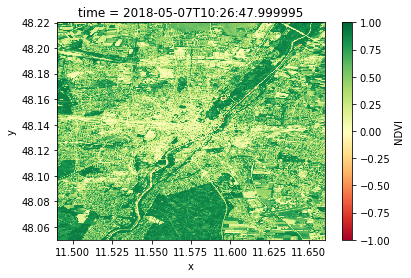

In [11]:
ds['NDVI'].isel(time=2).plot(cmap="RdYlGn")

#### NDVI plot for all times in the cube
**Please note:** Only clouds visible in the first and second time.

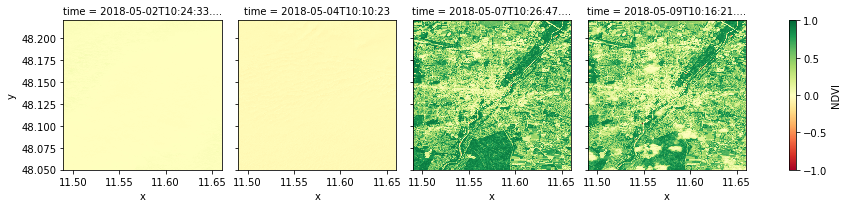

In [12]:
ds['NDVI'].plot(x='x', y='y', col='time', col_wrap=4, cmap="RdYlGn")

#### NDBI (Buildup index) plot for a specific point in time
**Please note:** Color scales need to be adjusted correctly in the plot to identify buildup areas. This needs to be enhanced in an upcoming version of this notebook.

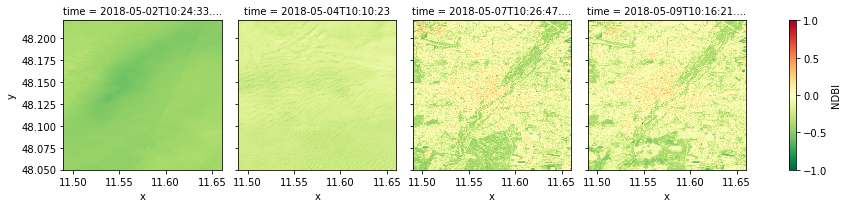

In [13]:
ds['NDBI'].plot(x='x', y='y', col='time', col_wrap=4, cmap="RdYlGn_r")

### Output gdalinfo for NDVI band

In [14]:
!gdalinfo NETCDF:"cube_s2.nc":NDVI

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Driver: netCDF/Network Common Data Format
Files: cube_s2.nc
Size is 512, 512
Origin = (11.489833430534706,48.220167563152870)
Pixel Size = (0.000332681166916,-0.000332684899496)
Metadata:
  NETCDF_DIM_EXTRA={time}
  NETCDF_DIM_time_DEF={4,6}
  NETCDF_DIM_time_VALUES={17683618.40944444,17683666.17305556,17683738.44666667,17683786.2725}
  time#calendar=gregorian
  time#units=hours since 0001-01-01 00:00:00.0
Corner Coordinates:
Upper Left  (  11.4898334,  48.2201676) 
Lower Left  (  11.4898334,  48.0498329) 
Upper Right (  11.6601662,  48.2201676) 
Lower Right (  11.6601662,  48.0498329) 
Center      (  11.5749998,  48.1350002) 
Band 1 Block=512x512 Type=Float32, ColorInterp=Undefined
  NoData Value=9.96920996838686905e+36
  Metadata:
    NETCDF_DIM_time=17683618.40944444
    NETCDF_VARNAME=NDVI
Band 2 Block=512x512 Type=Float32, ColorInterp=Undefined
  NoData Value=9.96920996838686905e+36
  Metadata:
    NETCDF_DIM_time=17683666.1730